- Config Calculation

In [ ]:
import numpy as np
import math

def cutoff_amounts(data, percentage):
    # Ensure percentage is between 0 and 100
    if not (0 <= percentage <= 100):
        raise ValueError("Percentage must be between 0 and 100.")

    # Calculate the number of elements to keep
    keep = float(len(data) * (percentage / 100)) - int(len(data) * (percentage / 100))
    num_elements_to_keep = int(len(data) * (percentage / 100))
    # Return the list up to the calculated index
    if keep > 0:
      return data[:num_elements_to_keep] + [data[num_elements_to_keep]*keep]
    else:
      return data[:num_elements_to_keep]

def cutoff_spread(data, percentage):
    # Ensure percentage is between 0 and 100
    if not (0 <= percentage <= 100):
        raise ValueError("Percentage must be between 0 and 100.")

    # Calculate the number of elements to keep
    keep = float(len(data) * (percentage / 100)) - int(len(data) * (percentage / 100))
    num_elements_to_keep = int(len(data) * (percentage / 100))
    if keep > 0:
      return data[:num_elements_to_keep+1]
    else:
      return data[:num_elements_to_keep]


def amounts(amount,levels,sf,base_pos,IRA,toggle):

  factors = [sf ** i for i in range(levels)]
  total_factors = sum(factors)
  amounts = [round((factor / total_factors) * amount,2) for factor in factors]
  bid_amounts, ask_amounts = amounts, amounts
  if not toggle:
    return bid_amounts, ask_amounts

  if base_pos > 0:
    asf = sf - 0.5*base_pos*IRA
    bsf = sf + 0.5*base_pos*IRA
  else:
    asf = sf - 0.5*base_pos*IRA
    bsf = sf + 0.5*base_pos*IRA


  bid_factors = [bsf ** i for i in range(levels)]
  ask_factors = [asf ** i for i in range(levels)]

  # Calculate the total of the factors to proportionally divide the amount
  total_bfactors = sum(bid_factors)
  total_afactors = sum(ask_factors)

  # Calculate each level's value as a proportion of the total factors
  bid_amounts = [round((factor / total_bfactors) * amount,2) for factor in bid_factors]
  ask_amounts = [round((factor / total_afactors) * amount,2) for factor in ask_factors]
  return bid_amounts,ask_amounts

def scaled_geomspace(start, stop, num=50, scale_factor=1.0):
    # Log-transform the start and stop values
    log_start = np.log10(start)
    log_stop = np.log10(stop)

    # Create evenly spaced points in the log space
    logspace_points = np.linspace(0, 1, num)

    # Apply the scaling to the middle points (keep start and stop the same)
    scaled_logspace_points = log_start + (log_stop - log_start) * (logspace_points ** scale_factor)

    # Return the sequence back in the original scale
    return 10 ** scaled_logspace_points


def spreads(b_bid,b_ask,levels,sf,pct):
  bid_values = scaled_geomspace(b_bid,pct,levels,sf)
  ask_values = scaled_geomspace(b_ask,pct,levels,sf)

  bid_values = [round(value, 3) for value in bid_values]
  ask_values = [round(value, 3) for value in ask_values]

  return bid_values,ask_values

def depth_factor(cp,max_spread,gamma,volatility):
  return(gamma/(np.exp((max_spread*cp*gamma-(volatility**2)*(gamma**2))/2)-1))

def reservation_price(cp,base_position,gamma,t,volatility):
  return (cp - (base_position*gamma*(volatility**2)*(1-t)))

def order_refresh_times(levels,IRA,base_pos,toggle):
  default = np.linspace(30,60,levels)
  default = [round(value, 2) for value in default]
  bid_orts = default
  ask_orts = default
  if not toggle:
    return bid_orts,ask_orts
  if base_pos > 0:
    if base_pos > 0.65: #might change later
      bid_orts = [round(i*(0.35),2) for i in bid_orts]
    else:
      bid_orts = [round(i*(1-abs(base_pos*IRA)),2) for i in bid_orts]
  else:
    if base_pos < -0.65:
      ask_orts = [round(i*0.35,2) for i in ask_orts]
    else:
      ask_orts = [round(i*(1-abs(base_pos*IRA)),2) for i in ask_orts]

  return bid_orts,ask_orts

def filled_order_delays(levels,IRA,base_pos,toggle):
  default = np.linspace(20,50,levels)
  default = [round(value,2) for value in default]
  bid_fods, ask_fods = default,default
  if not toggle:
    return bid_fods,ask_fods
  if base_pos < 0:
    if base_pos < -0.65:
      bid_fods = [round(i*(1-0.65),2) for i in bid_fods]
    else:
      bid_fods = [round(i*(1-abs(base_pos*IRA)),2) for i in bid_fods]
  else:
    if base_pos > 0.65:
      ask_fods = [round(i*0.35,2) for i in ask_fods]
    else:
      ask_fods = [round(i*(1-abs(base_pos*IRA)),2) for i in ask_fods]

  return bid_fods,ask_fods

def order_refresh_tolerances(IRA,base_pos,toggle):
  default = 1
  bid_ort = default
  ask_ort = default
  if not toggle:
    return [bid_ort,ask_ort]
  if base_pos > 0:
    if base_pos > 0.75:
      bid_ort = 0.5
      ask_ort = 2
    else:
      bid_ort = default - (0.5*abs(base_pos*IRA))
      ask_ort = default + (0.5*abs(base_pos*IRA))
  else:
    if base_pos < -0.75: #might change later
      bid_ort = 2
      ask_ort = 0.5
    else:
      bid_ort = default + (0.5*abs(base_pos*IRA))
      ask_ort = default - (0.5*abs(base_pos*IRA))

  return [bid_ort,ask_ort]

def optimal_spread(gamma,volatility,t,k):
  print(f"kappa:{k}")
  return (gamma*(volatility**2)*(1-t) + (2/gamma)*math.log(1 + (gamma/k)))

def reward_function(s_quote,c_quote,s_base,c_base,cp):
  reward = 1
  if s_base == c_base or s_quote == c_quote:
    return reward
  avg_position = (s_quote-c_quote)/(c_base-s_base)
  print("Average_position ",avg_position)
  if avg_position < 0:
    return reward
  elif c_quote < s_quote:
    pos = 'long'
    print(pos)
    if cp > avg_position:
      reward = ((cp-avg_position)/avg_position)*50
      if reward < 1:
        return 1
      if reward > 80:
        reward = 80
      return reward
    else:
      return reward
  else:
    pos = 'short'
    print(pos)
    if cp < avg_position:
      reward = ((avg_position-cp)/avg_position)*50
      if reward < 1:
        return 1
      if reward > 80:
        reward = 80
      return reward
    else:
      return reward

def generate_config(pct,amount,levels,sf,sf_,s_base,c_base,s_quote,c_quote,cp,volatility,max_spread,IRA,toggle_ortime,toggle_fod,toggle_ortol,toggle_amounts,fillpct):
  t = 0
  reward_factor = reward_function(s_quote,c_quote,s_base,c_base,cp)
  print("Reward factor ", reward_factor)
  gamma = (1/cp)*IRA*6*reward_factor
  base_position = ((c_base-s_base)/(s_base))
  k = depth_factor(cp,max_spread,gamma,volatility)
  res_price = reservation_price(cp,base_position,gamma,t,volatility)
  spread = (optimal_spread(gamma,volatility,t,k))/2
  print(" Current skew from starting ")
  print(base_position*100,"%")
  bbid = res_price - spread
  bask = res_price + spread
  bbidpct = (bbid/cp)
  baskpct = (bask/cp)
  bbidpct = np.round((1-bbidpct)*100,3)
  baskpct = np.round((baskpct-1)*100,3)
  if bbidpct < 0.005:
    bbidpct = 0.005
    baskpct = 0.595
  if baskpct < 0.005:
    baskpct = 0.005
    bbidpct - 0.595
  bid_amounts = amounts(amount,levels,sf,base_position,IRA,toggle_amounts)[0]
  ask_amounts = amounts(amount,levels,sf,base_position,IRA,toggle_amounts)[1]
  spreads_ = spreads(bbidpct,baskpct,levels,sf_,pct)
  orts = order_refresh_times(levels,IRA,base_position,toggle_ortime)
  fods = filled_order_delays(levels,IRA,base_position,toggle_fod)
  bid_ort = order_refresh_tolerances(IRA,base_position,toggle_ortol)[0]
  ask_ort = order_refresh_tolerances(IRA,base_position,toggle_ortol)[1]
  print("")
  print("Spreads on bids: ",spreads_[0])
  print("Spreads on asks: ",spreads_[1])
  print("")
  print("Bid Amounts: ", bid_amounts)
  print("Ask Amounts: ", ask_amounts)
  print("")
  print("Bid Order Refresh Times: ", orts[0])
  print("Ask Order Refresh Times: ", orts[1])
  print("")
  print("Bid Filled Order Delays: ", fods[0])
  print("Ask Filled Order Delays: ", fods[1])
  print("")
  print("Bid Order Refresh Tolerance: ",bid_ort)
  print("Ask Order Refresh Tolerance: ",ask_ort)

  bidspread = spreads_[0]
  askspread = spreads_[1]
  bidspread = cutoff_spread(bidspread,fillpct)
  askspread = cutoff_spread(askspread,fillpct)
  bid_amounts = cutoff_amounts(bid_amounts,fillpct)
  ask_amounts = cutoff_amounts(ask_amounts,fillpct)

  bidprices = [(cp*(1-i/100)) for i in bidspread]
  askprices = [(cp*(1+i/100)) for i in askspread]
  avg_bid_wipe = sum([a*b for a,b in zip(bidprices,bid_amounts)])/sum(bid_amounts)
  avg_ask_wipe = sum([a*b for a,b in zip(askprices,ask_amounts)])/sum(ask_amounts)
  print("")
  print("Avg Price on ", fillpct, "% of Bids Filled: ", avg_bid_wipe)
  print("Buy Amount: ", round(sum(bid_amounts),2))
  print(" ")
  print("Avg Price on  ", fillpct,"% of Asks Filled: ", avg_ask_wipe)
  print("Sell Amount: ", round(sum(ask_amounts),2))



- Real life example: CORE/USDT GATE 1/10/2024

In [ ]:
#Market
s_base = 5500
c_base = 11903.222
s_quote = 55
c_quote = 1.591
cp = 0.006630
volatility = 0.000175367315082587

#Clients
depth = 2 #as a percentage
amount = 1500

#Traders
max_spread =  0.5/100
levels = 6
IRA = 0.5 # Scale from 0.1-1 (Aggressiveness of rebalancing, the more aggressive it is, the less potential P/L variance)
amount_sf = 2 # Scale from 1.4-2.2 (Smaller number has a higher amount in the closer orders and vice versa)
spread_sf = 1.25 # Scale from 0-1.5 (Smaller number has tighter spread to further orders, larger number has tighter spread to closer orders)

#Constraints
toggle_ortime = True
toggle_fod = True
toggle_ortol = True
toggle_amounts = False

#Final config
fillpct = 100 #will calculate metrics based off what percentage of your order group has been filled
generate_config(depth,amount,levels,amount_sf,spread_sf,s_base,c_base,s_quote,c_quote,cp,volatility,max_spread,IRA,toggle_ortime,toggle_fod,toggle_ortol,toggle_amounts,fillpct)

#Make sure amounts can't be 0

#fix reward factor


Average_position  0.008340957099410266
long
Reward factor  1
kappa:103754.82444571577
 Current skew from starting 
116.42221818181817 %

Spreads on bids:  [0.494, 0.596, 0.771, 1.034, 1.423, 2.0]
Spreads on asks:  [0.006, 0.013, 0.038, 0.129, 0.486, 2.0]

Bid Amounts:  [23.81, 47.62, 95.24, 190.48, 380.95, 761.9]
Ask Amounts:  [23.81, 47.62, 95.24, 190.48, 380.95, 761.9]

Bid Order Refresh Times:  [10.5, 12.6, 14.7, 16.8, 18.9, 21.0]
Ask Order Refresh Times:  [30.0, 36.0, 42.0, 48.0, 54.0, 60.0]

Bid Filled Order Delays:  [20.0, 26.0, 32.0, 38.0, 44.0, 50.0]
Ask Filled Order Delays:  [7.0, 9.1, 11.2, 13.3, 15.4, 17.5]

Bid Order Refresh Tolerance:  0.5
Ask Order Refresh Tolerance:  2

Avg Price on  100 % of Bids Filled:  0.0065249621533459996
Buy Amount:  1500.0
 
Avg Price on   100 % of Asks Filled:  0.006706814943972
Sell Amount:  1500.0


- Yang Zhang Volatility Calculation

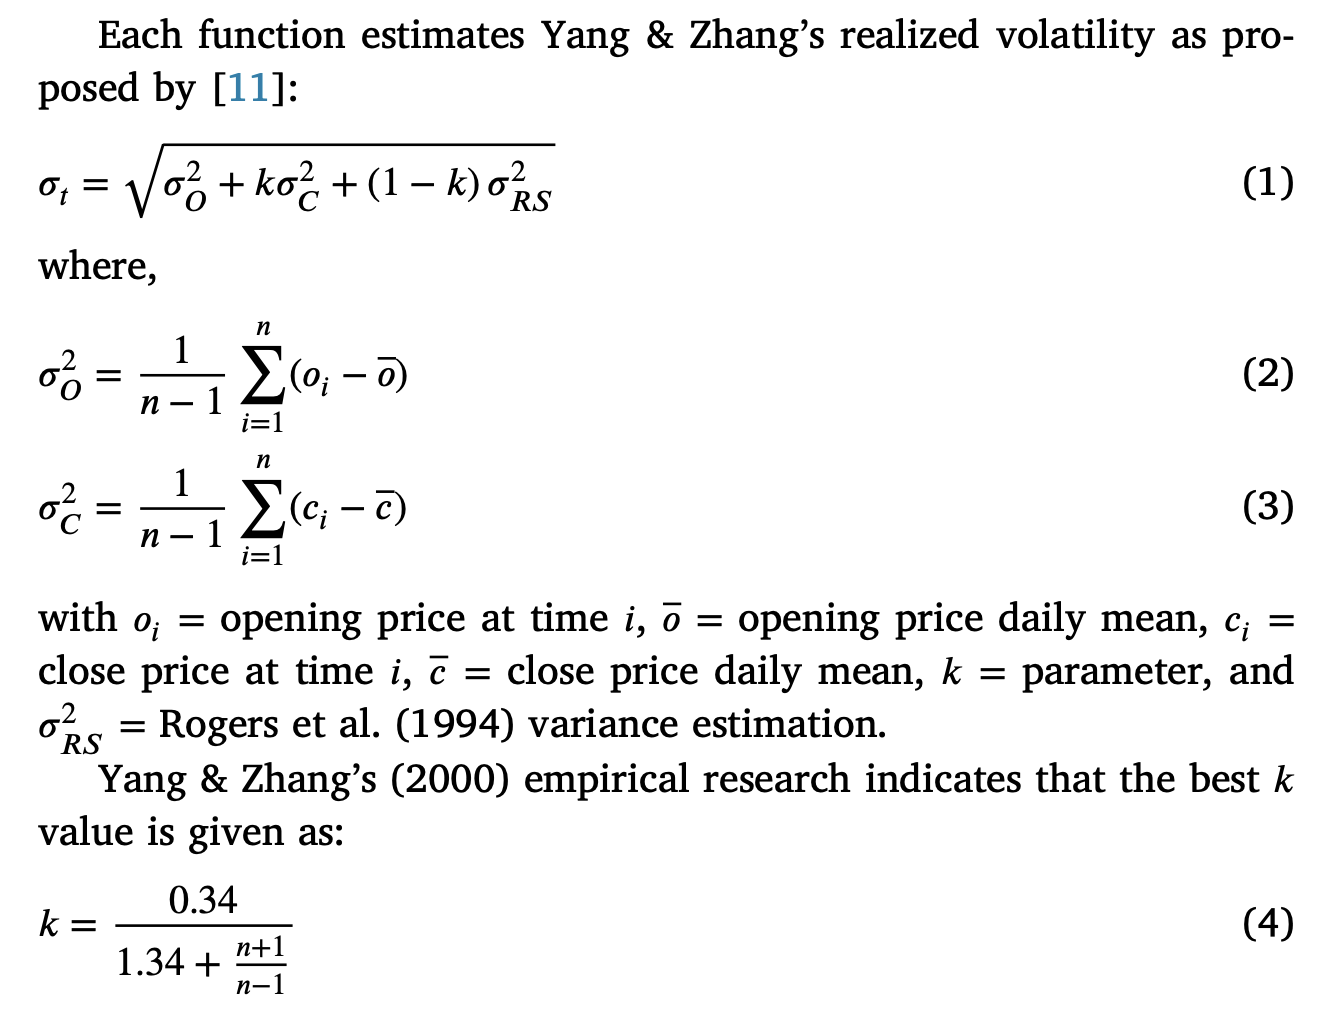

- The Yang Zhang volatility use candlestick data to calculate. It need Open, High, Low, and Close price.
- The final volatility is the formula of three smaller volatility, which are:
  + Volatility of current Close and Open
  + Volatility of current Open and last candle's Close
  + Rogers-Satchell volatility which take account of all current four Open, High, Low, and Close.
- The Stoikov model use volatility with unit of $, so I adjust Yang Zhang volatility to keep the right unit.

In [ ]:
import yfinance as yf
import numpy as np
import pandas as pd

# Define the rolling window size
rolling_window_size = 23  # You can change this value as needed

# Read file
data = pd.read_excel("F3.xlsx")

# Calculate price differences
data['price_diff_oc'] = data['Close'] - data['Open']  # Open to Close price difference
data['price_diff_co'] = data['Open'] - data['Close'].shift(1)  # Close to Open (overnight) price difference

# Calculate daily ranges for Rogers-Satchell part (using prices directly)
data['range_hl'] = data['High'] - data['Low']
data['range_ho'] = data['High'] - data['Open']
data['range_lo'] = data['Open'] - data['Low']

# Rogers-Satchell volatility formula using prices directly
def rogers_satchell(row):
    return (row['range_ho'] * (row['range_ho'] - row['price_diff_oc']) +
            row['range_lo'] * (row['range_lo'] - row['price_diff_oc']))

data['rogers_satchell'] = data.apply(rogers_satchell, axis=1)

# Yang-Zhang volatility formula using prices directly
def yang_zhang_volatility(price_diff_co, price_diff_oc, rogers_satchell):
    mean_price_diff_co = np.mean(price_diff_co) ** 2
    mean_price_diff_oc = np.mean(price_diff_oc) ** 2
    mean_rogers_satchell = np.mean(rogers_satchell)

    n = len(price_diff_co)
    k = 0.34 / (1.34 + (n + 1) / (n - 1))  # Weighting factor
    return np.sqrt(mean_price_diff_co + k * mean_price_diff_oc + (1 - k) * mean_rogers_satchell)

# Apply rolling window separately to each price-based column using the defined rolling window size
price_diff_co_rolling = data['price_diff_co'].rolling(window=rolling_window_size).mean()
price_diff_oc_rolling = data['price_diff_oc'].rolling(window=rolling_window_size).mean()
rogers_satchell_rolling = data['rogers_satchell'].rolling(window=rolling_window_size).mean()

# Calculate Yang-Zhang volatility for each rolling window using price differences directly
data['YZ_volatility_rolling'] = np.sqrt(
    price_diff_co_rolling ** 2 +
    (0.34 / (1.34 + (rolling_window_size + 1) / (rolling_window_size - 1))) * price_diff_oc_rolling ** 2 +
    (1 - 0.34 / (1.34 + (rolling_window_size + 1) / (rolling_window_size - 1))) * rogers_satchell_rolling
)

# Calculate traditional volatility (standard deviation of closing prices)
data['traditional_volatility'] = data['Close'].rolling(window=rolling_window_size).std()

# Drop any NaN values that may appear due to rolling window
data.dropna(inplace=True)

# Show the result
data


Improvements:
- Analyse market sentiment to auto adapt the variables
- Analyse filled orders distribution of each token to auto adapt the variables
- If everything is calculated on the server, we expected the config updated in real time or at least every 1 minute.
